## IMPORTACIÓN DE LIBRERÍAS

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import entropy
import pyhomogeneity as hg
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller, bds
from statsmodels.graphics.tsaplots import plot_acf

In [16]:
plt.rcParams.update({
    'figure.figsize': (16, 9),
    'lines.linewidth': 2,
    'lines.color': 'royalblue',
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.titleweight': 'bold',
    'grid.linestyle': '--'
})

In [17]:
df = pd.DataFrame (pd.read_csv("../data/raw/Precipitation_complete.csv"))

## Trend and level 

In [18]:
mk_result = mk.original_test(df['precipitation'],alpha=0.01)
print (mk_result)

Mann_Kendall_Test(trend='no trend', h=False, p=0.8728592360164749, z=0.1600277227764737, Tau=0.005632930981120396, s=364.0, var_s=5145443.333333333, slope=0.0, intercept=4.0)


In [19]:
# Resultado del test Mann-Kendall
trend = mk_result.trend
slope = mk_result.slope
intercept = mk_result.intercept

# Calcular la línea de tendencia
trend_line = slope * np.arange(len(df)) + intercept
nivel = np.full(len(df), df['precipitation'].mean())

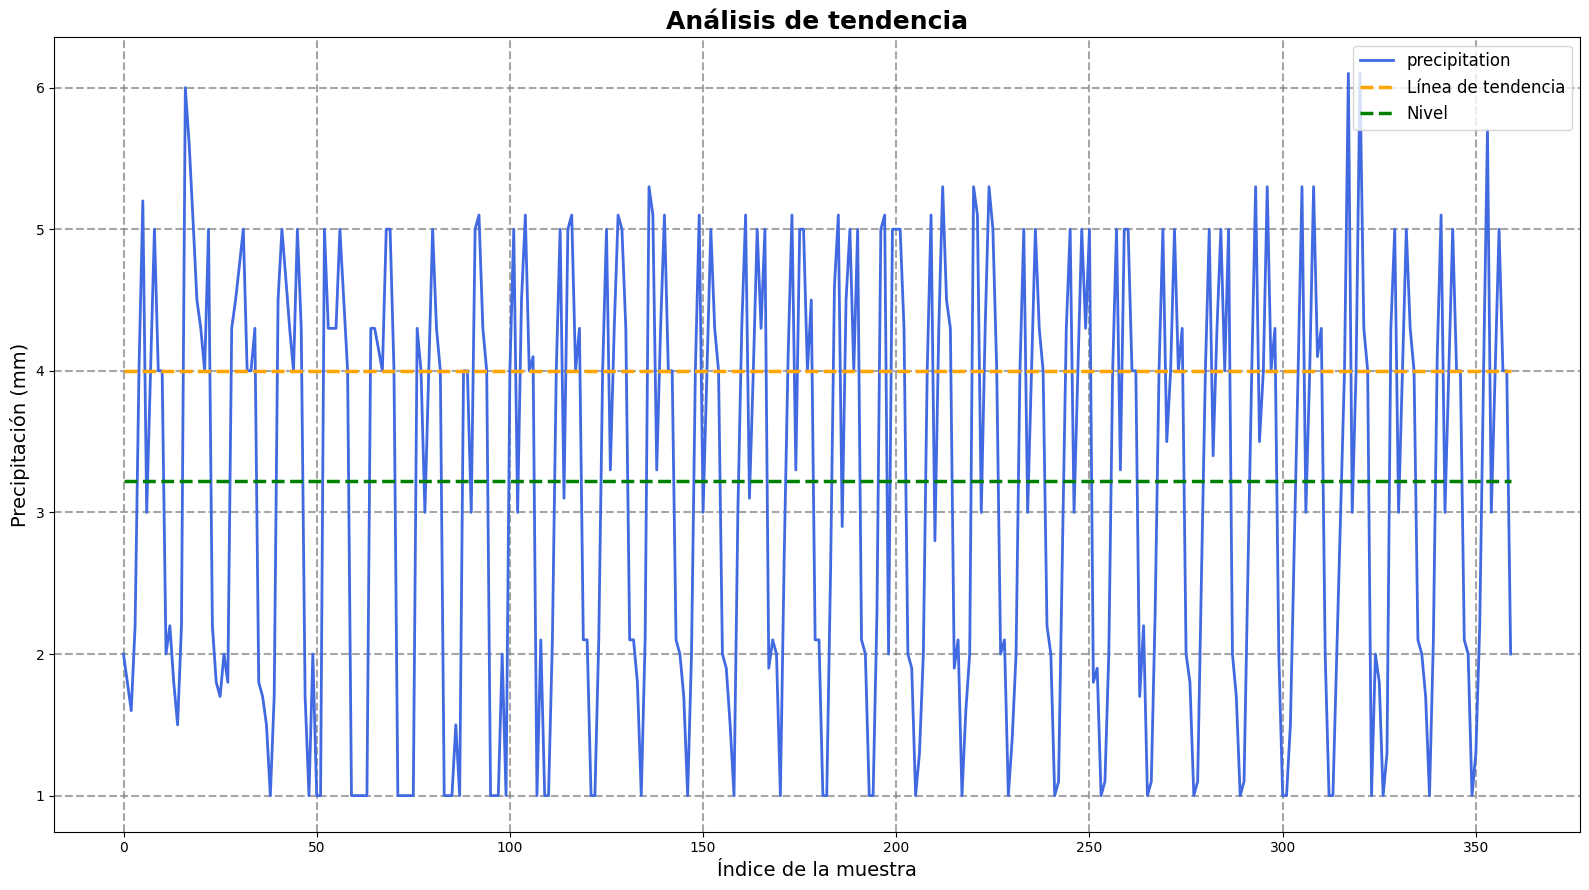

In [20]:
plt.plot (np.arange(len(df ['precipitation'])),df['precipitation'],label='precipitation', color='royalblue')
plt.plot(np.arange(len(df ['precipitation'])), trend_line, label='Línea de tendencia', color='orange', linestyle='--', lw=2.5)  # Usar mismo eje x que trend_line
plt.plot(np.arange(len(df ['precipitation'])), nivel, label='Nivel', color='green', linestyle='--', lw=2.5)  # Usar mismo eje x

plt.title('Análisis de tendencia', fontsize=18)
plt.xlabel('Índice de la muestra', fontsize=14)  # Cambiado a "Índice"
plt.ylabel('Precipitación (mm)', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()

**Interpretación General**:
El test muestra que no hay una tendencia significativa en los datos (`no trend`), el valor p es alto, y la pendiente es `0.0`, lo que confirma que los valores no están aumentando ni disminuyendo de manera significativa a lo largo del tiempo. Esto indica estabilidad o ausencia de un patrón direccional en la serie temporal analizada.

### Estacionalidad

In [21]:
# Calcular el valor promedio de Precipitación mensual
mediana_mensual = df.groupby('month')['precipitation'].median()

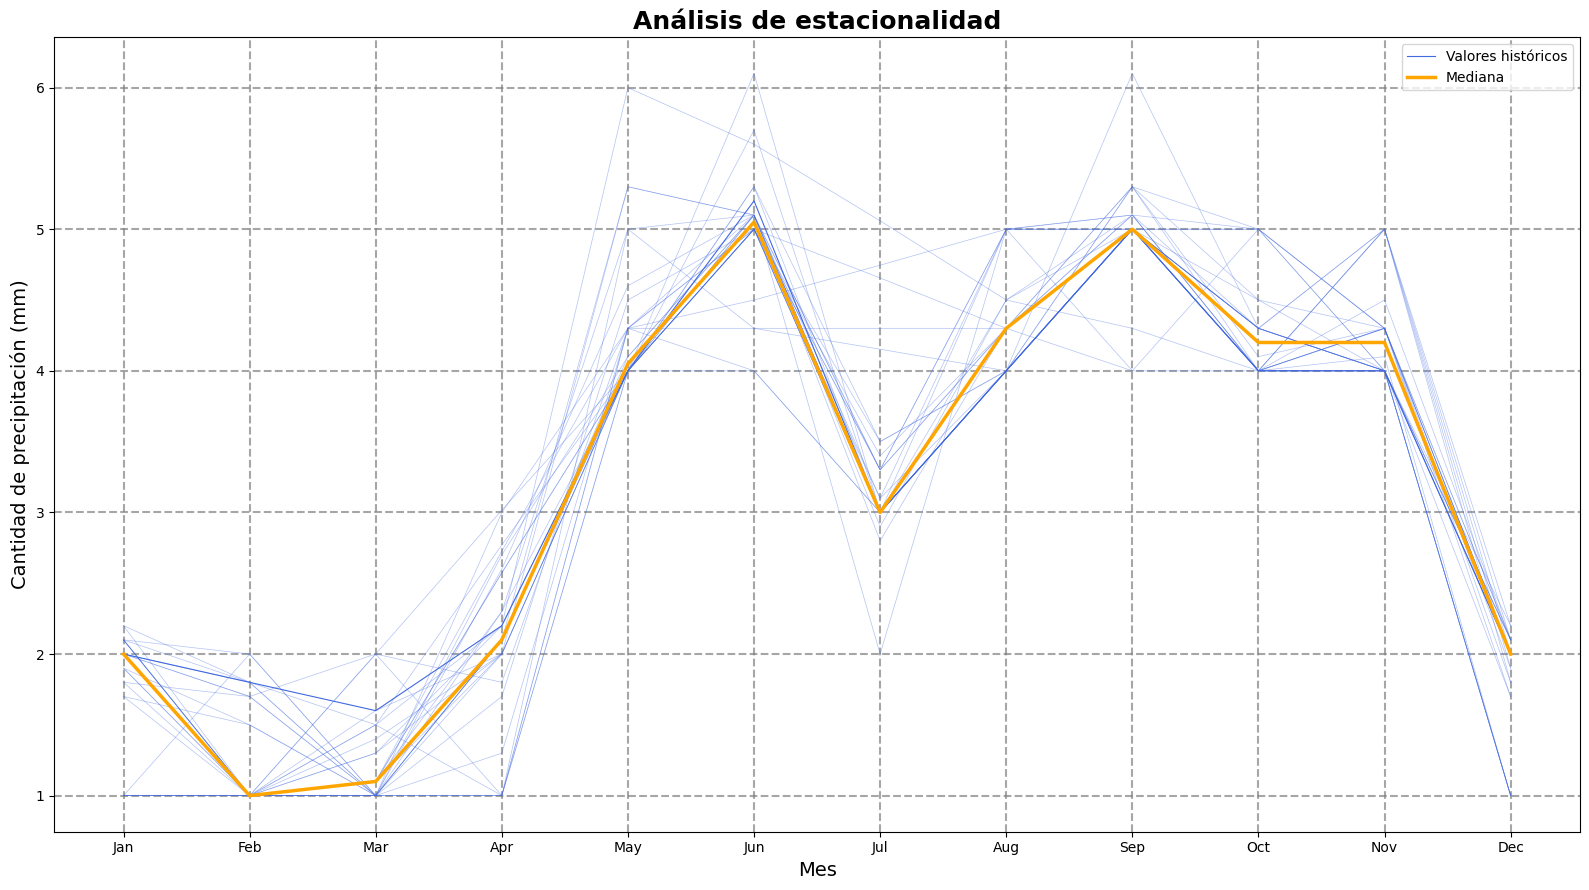

In [22]:
años = df['year'].unique()
month_name = df['month_name'].unique()

# Primer año
primer_año = df[df['year'] == años[0]]['precipitation'].values
plt.plot(month_name, primer_año, '-', color='royalblue', linewidth=0.8, label='Valores históricos')

# Años siguientes (1992 en adelante)
for año in años[1:]:
    datos_año = df [df['year'] == año]['precipitation'].values
    plt.plot(month_name, datos_año, '-', color='royalblue', linewidth=0.5, alpha=0.4)

plt.plot(month_name, mediana_mensual, color='orange', linewidth=2.5, label='Mediana')

plt.title('Análisis de estacionalidad', fontsize=18)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Cantidad de precipitación (mm)', fontsize=14)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.tight_layout()
plt.legend()

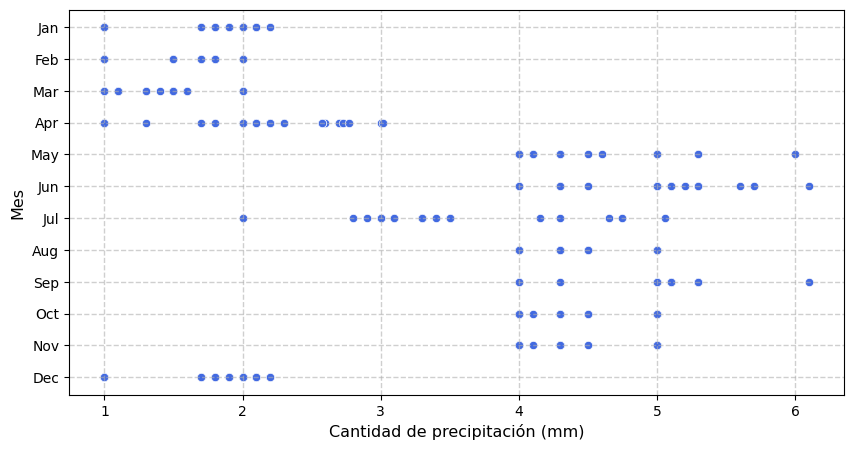

In [23]:
plt.figure(figsize=(10,5))
sns.scatterplot(data = df, x = 'precipitation', y='month_name', color = 'royalblue')
plt.xlabel ('Cantidad de precipitación (mm)').set_fontsize(11.5)
plt.ylabel ('Mes').set_fontsize(11.5)
plt.grid(linewidth=1, alpha=0.6)

### Estacionariedad 

In [24]:
def adf_test (timeseries):
    print ('Results of the Dickey-Fuller Test:')
    dftest = adfuller (timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            'Test Statistic',
            'p-value',
            'Lags Number',
            'Number of Observation Used'
        ]
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print (dfoutput)
    
    # Interpretación
    if dftest[1] < 0.01:
        print("Rechazamos la hipótesis nula: la serie es estacionaria.")
    else:
        print("No se rechaza la hipótesis nula: la serie tiene una raíz unitaria y es no estacionaria.")

In [26]:
adf_test(df['precipitation'])

Results of the Dickey-Fuller Test:
Test Statistic                 -2.368781
p-value                         0.150742
Lags Number                    11.000000
Number of Observation Used    348.000000
Critical Value (1%)            -3.449282
Critical Value (5%)            -2.869881
Critical Value (10%)           -2.571214
dtype: float64
No se rechaza la hipótesis nula: la serie tiene una raíz unitaria y es no estacionaria.


**Interpretación general**: No se rechaza la hipótesis nula de que la serie tiene una raíz unitaria, es decir, no hay suficiente evidencia para afirmar que la serie es estacionaria.

### Periodicidad

In [29]:
def comprobar_periodicidad(df, muestra):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)  

    # Calcular la fecha esperada para el siguiente mes
    df['Tiempo_siguiente_mes'] = df.index + pd.offsets.MonthBegin(1)

    # Calcular la diferencia excluyendo la última muestra
    df['Diferencia'] = df['Tiempo_siguiente_mes'].shift(1) - df.index

    # Filtrar diferencias no nulas (excluyendo el primer valor que es NaN por el shift)
    inconsistencias = df[df['Diferencia'] != pd.Timedelta(0)].dropna(subset=['Diferencia'])

    if inconsistencias.empty:
        print("Todas las muestras de precipitación se han tomado en intervalos de 1 mes.")
    else:
        print("Hay intervalos de tiempo inconsistentes en las muestras de precipitación.")
        print("Inconsistencias encontradas:")
        print(inconsistencias[['Tiempo_siguiente_mes', 'Diferencia']])

In [30]:
comprobar_periodicidad(df, 'precipitation')

Hay intervalos de tiempo inconsistentes en las muestras de precipitación.
Inconsistencias encontradas:
                                       Tiempo_siguiente_mes  \
1970-01-01 00:00:00.000000001 1970-02-01 00:00:00.000000001   
1970-01-01 00:00:00.000000002 1970-02-01 00:00:00.000000002   
1970-01-01 00:00:00.000000003 1970-02-01 00:00:00.000000003   
1970-01-01 00:00:00.000000004 1970-02-01 00:00:00.000000004   
1970-01-01 00:00:00.000000005 1970-02-01 00:00:00.000000005   
...                                                     ...   
1970-01-01 00:00:00.000000355 1970-02-01 00:00:00.000000355   
1970-01-01 00:00:00.000000356 1970-02-01 00:00:00.000000356   
1970-01-01 00:00:00.000000357 1970-02-01 00:00:00.000000357   
1970-01-01 00:00:00.000000358 1970-02-01 00:00:00.000000358   
1970-01-01 00:00:00.000000359 1970-02-01 00:00:00.000000359   

                                              Diferencia  
1970-01-01 00:00:00.000000001 30 days 23:59:59.999999999  
1970-01-01 00:00:00.00

### Homogeneidad


In [31]:
result_snht = hg.snht_test(df['precipitation'])
print (result_snht)

SNHT_Test(h=False, cp='1970-01-01', p=0.8116, T=3.1700637890934455, avg=mean(mu1=1.9000000000000001, mu2=3.2353195800331553))


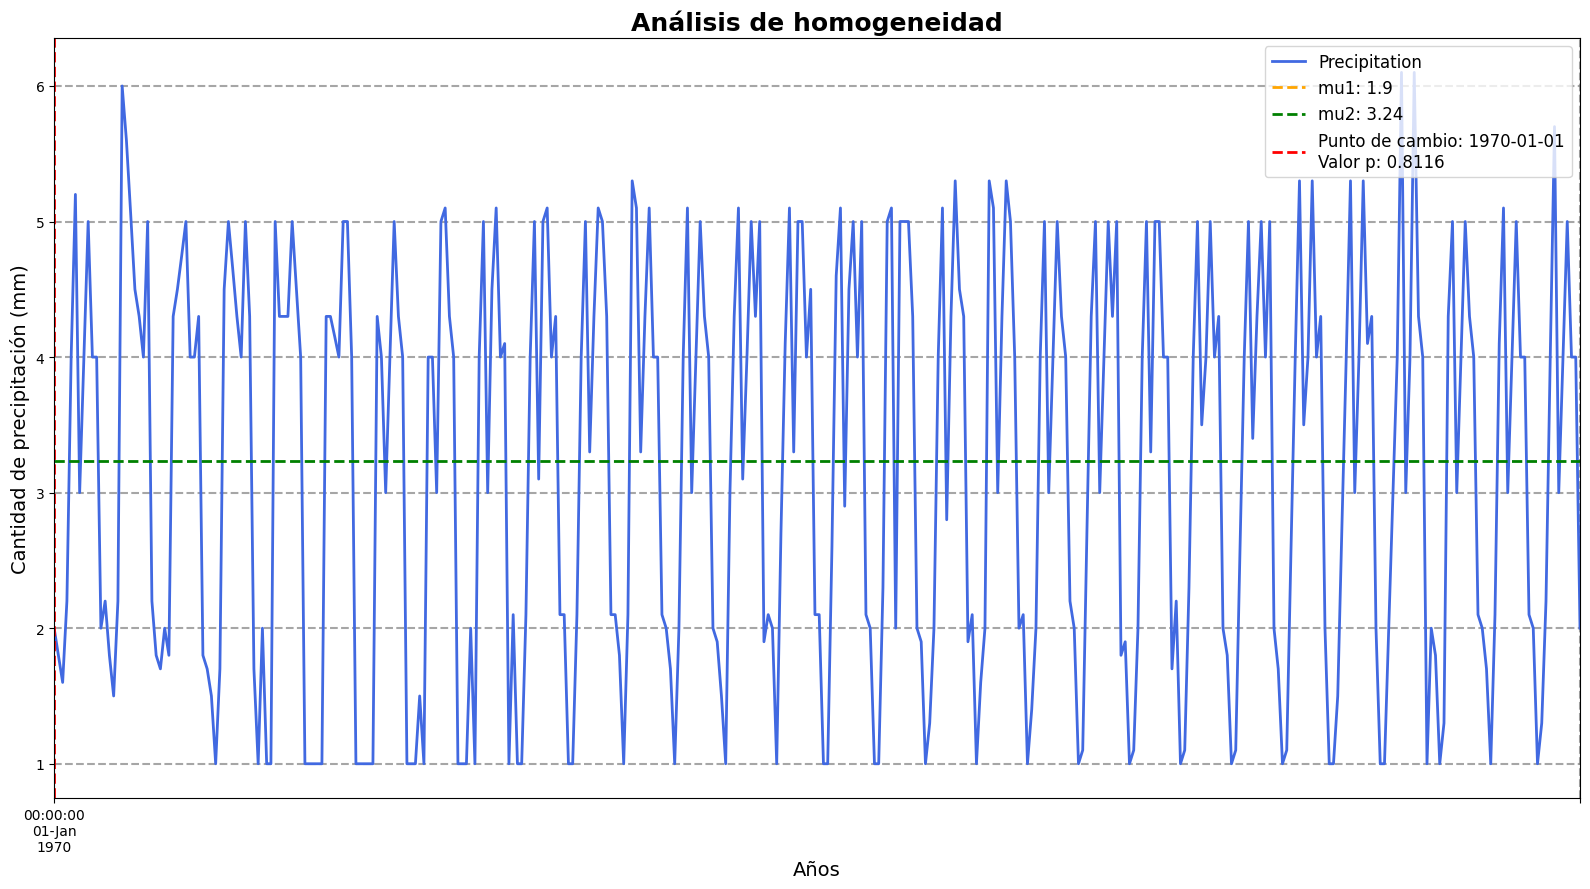

In [34]:
# Obtener estadísticos del test
loc = result_snht.cp         # Fecha del punto de cambio (ej: '1991-04-01')
mu1 = result_snht.avg.mu1    # Promedio antes del cambio
mu2 = result_snht.avg.mu2    # Promedio después del cambio

# Graficar la serie de precipitación
df['precipitation'].plot(label='Precipitation', color='royalblue')

# Líneas horizontales (usando fechas)
plt.hlines(mu1, 
           xmin=df.index.min(),  
           xmax=pd.to_datetime(loc),       
           linestyles='--', lw=2, colors='orange', 
           label=f'mu1: {round(mu1, 2)}')

plt.hlines(mu2, 
           xmin=pd.to_datetime(loc),       
           xmax=df.index.max(),  
           linestyles='--', colors='g', lw=2, 
           label=f'mu2: {round(mu2, 2)}')

# Línea vertical del punto de cambio 
plt.axvline(x=pd.to_datetime(loc), 
            linestyle='--', color='red', lw=2,
            label=f'Punto de cambio: {loc}\nValor p: {result_snht.p}')

plt.title('Análisis de homogeneidad', fontsize = 18)
plt.xlabel('Años')
plt.ylabel('Cantidad de precipitación (mm)')
plt.legend(loc='upper right',fontsize = 12)
plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
plt.tight_layout()

**Interpretación General:**

Dado que no se detectó un cambio estadísticamente significativo en la serie temporal (con base en h=False y un valor p alto), se puede concluir que la serie es homogénea.

### No linealidad

In [37]:
def bds_test (timeseries, alpha):
    print ('Results of the BDS Test:')
    dftest = bds (timeseries)
    print (f'Test Statistic: {dftest[0]}')
    print (f'p-value: {dftest[1]}')
    if dftest[1] < alpha:               #se compara el p value con el nivel de significancia 
        print ('La serie es no lineal') 

bds_test(df['precipitation'], 0.01) #establecemos un nivel de significancia de 0.01



Results of the BDS Test:
Test Statistic: 29.095726815260896
p-value: 4.065787252981372e-186
La serie es no lineal


### Complejidad de la serie: autocorrelación

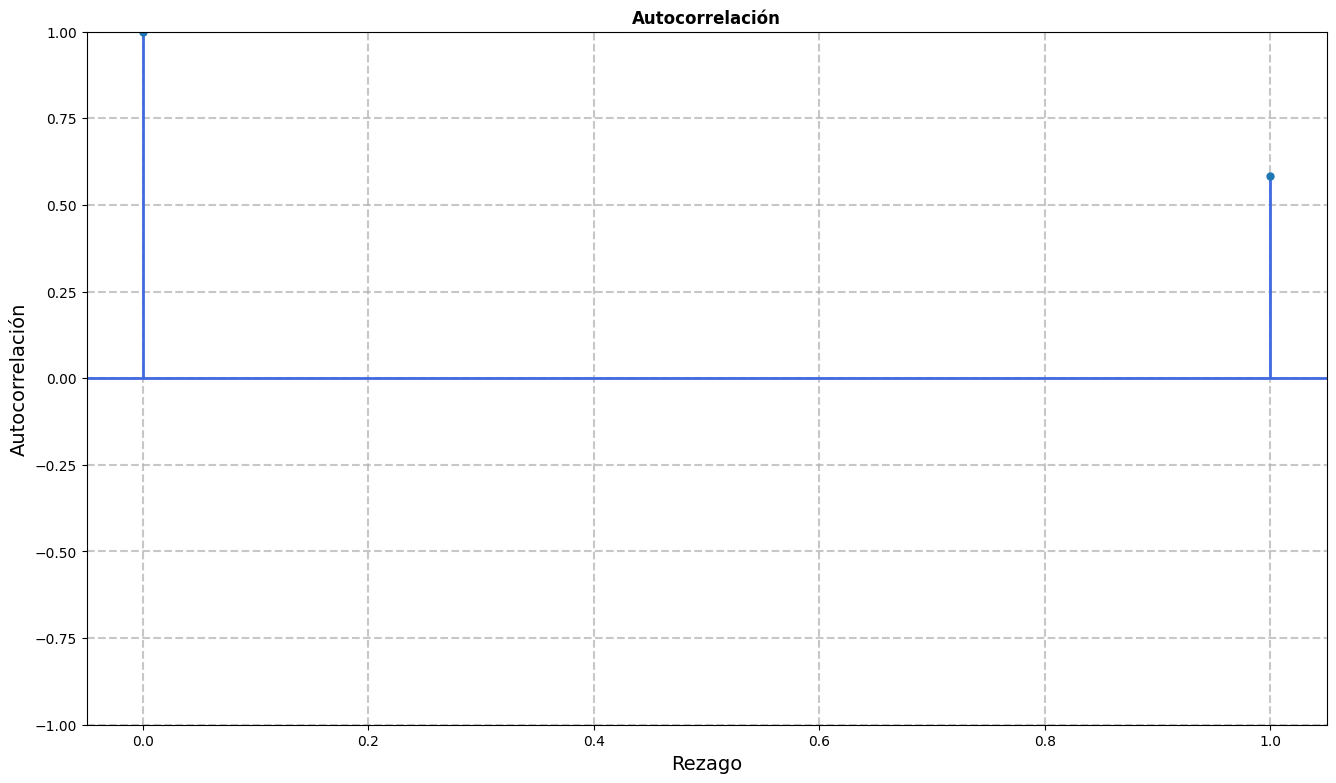

In [38]:
plot_acf(df['precipitation'],alpha=0.01,lags=1)
plt.title('Autocorrelación')
plt.xlabel ('Rezago')
plt.ylabel('Autocorrelación')
plt.grid(linewidth=1.5, alpha=0.7)
plt.show()